#  T S V D Unfold Example
<hr style="border-top-width: 4px; border-top-color: #34609b;">
 Data unfolding using Singular Value Decomposition

TSVDUnfold example

Data unfolding using Singular Value Decomposition (hep-ph/9509307)

Example distribution and smearing model from Tim Adye (RAL)




**Author:**  Kerstin Tackmann, Andreas Hoecker, Heiko Lacker  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:37 PM.</small></i>

In [1]:
%%cpp -d
#include <iostream>

#include "TROOT.h"
#include "TSystem.h"
#include "TStyle.h"
#include "TRandom3.h"
#include "TString.h"
#include "TMath.h"
#include "TH1D.h"
#include "TH2D.h"
#include "TLegend.h"
#include "TCanvas.h"
#include "TColor.h"
#include "TLine.h"

#include "TSVDUnfold.h"

 A helper function is created: 

In [2]:
%%cpp -d
Double_t Reconstruct( Double_t xt, TRandom3& R )
{
   // apply some Gaussian smearing + bias and efficiency corrections to fake reconstruction
   const Double_t cutdummy = -99999.0;
   Double_t xeff = 0.3 + (1.0 - 0.3)/20.0*(xt + 10.0);  // efficiency
   Double_t x    = R.Rndm();
   if (x > xeff) return cutdummy;
   else {
     Double_t xsmear= R.Gaus(-2.5,0.2); // bias and smear
     return xt+xsmear;
   }
}

In [3]:
gROOT->SetStyle("Plain");
gStyle->SetOptStat(0);

TRandom3 R;

const Double_t cutdummy= -99999.0;

--------------------------------------
 Data/MC toy generation

 The MC input

In [4]:
Int_t nbins = 40;
TH1D *xini = new TH1D("xini", "MC truth", nbins, -10.0, 10.0);
TH1D *bini = new TH1D("bini", "MC reco", nbins, -10.0, 10.0);
TH2D *Adet = new TH2D("Adet", "detector response", nbins, -10.0, 10.0, nbins, -10.0, 10.0);

Data

In [5]:
TH1D *data = new TH1D("data", "data", nbins, -10.0, 10.0);

Data "truth" distribution to test the unfolding

In [6]:
TH1D *datatrue = new TH1D("datatrue", "data truth", nbins, -10.0, 10.0);

Statistical covariance matrix

In [7]:
TH2D *statcov = new TH2D("statcov", "covariance matrix", nbins, -10.0, 10.0, nbins, -10.0, 10.0);

Fill the mc using a breit-wigner, mean 0.3 and width 2.5.

In [8]:
for (Int_t i= 0; i<100000; i++) {
   Double_t xt = R.BreitWigner(0.3, 2.5);
   xini->Fill(xt);
   Double_t x = Reconstruct( xt, R );
   if (x != cutdummy) {
      Adet->Fill(x, xt);
      bini->Fill(x);
   }
}

Fill the "data" with a gaussian, mean 0 and width 2.

In [9]:
for (Int_t i=0; i<10000; i++) {
   Double_t xt = R.Gaus(0.0, 2.0);
   datatrue->Fill(xt);
   Double_t x = Reconstruct( xt, R );
   if (x != cutdummy)
   data->Fill(x);
}

cout << "Created toy distributions and errors for: " << endl;
cout << "... \"true MC\"   and \"reconstructed (smeared) MC\"" << endl;
cout << "... \"true data\" and \"reconstructed (smeared) data\"" << endl;
cout << "... the \"detector response matrix\"" << endl;

Created toy distributions and errors for: 
... "true MC"   and "reconstructed (smeared) MC"
... "true data" and "reconstructed (smeared) data"
... the "detector response matrix"


Fill the data covariance matrix

In [10]:
for (int i=1; i<=data->GetNbinsX(); i++) {
    statcov->SetBinContent(i,i,data->GetBinError(i)*data->GetBinError(i));
}

----------------------------
 Here starts the actual unfolding

 Create TSVDUnfold object and initialise

In [11]:
TSVDUnfold *tsvdunf = new TSVDUnfold( data, statcov, bini, xini, Adet );

It is possible to normalise unfolded spectrum to unit area

In [12]:
tsvdunf->SetNormalize( kFALSE ); // no normalisation here

Perform the unfolding with regularisation parameter kreg = 13
 - the larger kreg, the finer grained the unfolding, but the more fluctuations occur
 - the smaller kreg, the stronger is the regularisation and the bias

In [13]:
TH1D* unfres = tsvdunf->Unfold( 13 );

Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.002960


Get the distribution of the d to cross check the regularization
 - choose kreg to be the point where |d_i| stop being statistically significantly >>1

In [14]:
TH1D* ddist = tsvdunf->GetD();

Get the distribution of the singular values

In [15]:
TH1D* svdist = tsvdunf->GetSV();

Compute the error matrix for the unfolded spectrum using toy mc
 using the measured covariance matrix as input to generate the toys
 100 toys should usually be enough
 The same method can be used for different covariance matrices separately.

In [16]:
TH2D* ustatcov = tsvdunf->GetUnfoldCovMatrix( statcov, 100 );

Now compute the error matrix on the unfolded distribution originating
 from the finite detector matrix statistics

In [17]:
TH2D* uadetcov = tsvdunf->GetAdetCovMatrix( 100 );

Sum up the two (they are uncorrelated)

In [18]:
ustatcov->Add( uadetcov );

Get the computed regularized covariance matrix (always corresponding to total uncertainty passed in constructor) and add uncertainties from finite mc statistics.

In [19]:
TH2D* utaucov = tsvdunf->GetXtau();
utaucov->Add( uadetcov );

Get the computed inverse of the covariance matrix

In [20]:
TH2D* uinvcov = tsvdunf->GetXinv();

---------------------------------
 Only plotting stuff below

In [21]:
for (int i=1; i<=unfres->GetNbinsX(); i++) {
   unfres->SetBinError(i, TMath::Sqrt(utaucov->GetBinContent(i,i)));
}

Renormalize just to be able to plot on the same scale

In [22]:
xini->Scale(0.7*datatrue->Integral()/xini->Integral());

TLegend *leg = new TLegend(0.58,0.60,0.99,0.88);
leg->SetBorderSize(0);
leg->SetFillColor(0);
leg->SetFillStyle(0);
leg->AddEntry(unfres,"Unfolded Data","p");
leg->AddEntry(datatrue,"True Data","l");
leg->AddEntry(data,"Reconstructed Data","l");
leg->AddEntry(xini,"True MC","l");

TCanvas *c1 = new TCanvas( "c1", "Unfolding toy example with TSVDUnfold", 1000, 900 );

c1->Divide(1,2);
TVirtualPad * c11 = c1->cd(1);

TH1D* frame = new TH1D( *unfres );
frame->SetTitle( "Unfolding toy example with TSVDUnfold" );
frame->GetXaxis()->SetTitle( "x variable" );
frame->GetYaxis()->SetTitle( "Events" );
frame->GetXaxis()->SetTitleOffset( 1.25 );
frame->GetYaxis()->SetTitleOffset( 1.29 );
frame->Draw();

data->SetLineStyle(2);
data->SetLineColor(4);
data->SetLineWidth(2);
unfres->SetMarkerStyle(20);
datatrue->SetLineColor(2);
datatrue->SetLineWidth(2);
xini->SetLineStyle(2);
xini->SetLineColor(8);
xini->SetLineWidth(2);

------------------------------------------------------------

Add histograms

In [23]:
unfres->Draw("same");
datatrue->Draw("same");
data->Draw("same");
xini->Draw("same");

leg->Draw();

Covariance matrix

In [24]:
TVirtualPad * c12 = c1->cd(2);
c12->Divide(2,1);
TVirtualPad * c2 = c12->cd(1);
c2->SetRightMargin   ( 0.15         );

TH2D* covframe = new TH2D( *ustatcov );
covframe->SetTitle( "TSVDUnfold covariance matrix" );
covframe->GetXaxis()->SetTitle( "x variable" );
covframe->GetYaxis()->SetTitle( "x variable" );
covframe->GetXaxis()->SetTitleOffset( 1.25 );
covframe->GetYaxis()->SetTitleOffset( 1.29 );
covframe->Draw();

ustatcov->SetLineWidth( 2 );
ustatcov->Draw( "colzsame" );

Distribution of the d quantity

In [25]:
TVirtualPad * c3 = c12->cd(2);
c3->SetLogy();

TLine *line = new TLine( 0.,1.,40.,1. );
line->SetLineStyle(2);

TH1D* dframe = new TH1D( *ddist );
dframe->SetTitle( "TSVDUnfold |d_{i}|" );
dframe->GetXaxis()->SetTitle( "i" );
dframe->GetYaxis()->SetTitle( "|d_{i}|" );
dframe->GetXaxis()->SetTitleOffset( 1.25 );
dframe->GetYaxis()->SetTitleOffset( 1.29 );
dframe->SetMinimum( 0.001 );
dframe->Draw();

ddist->SetLineWidth( 2 );
ddist->Draw( "same" );
line->Draw();

Draw all canvases 

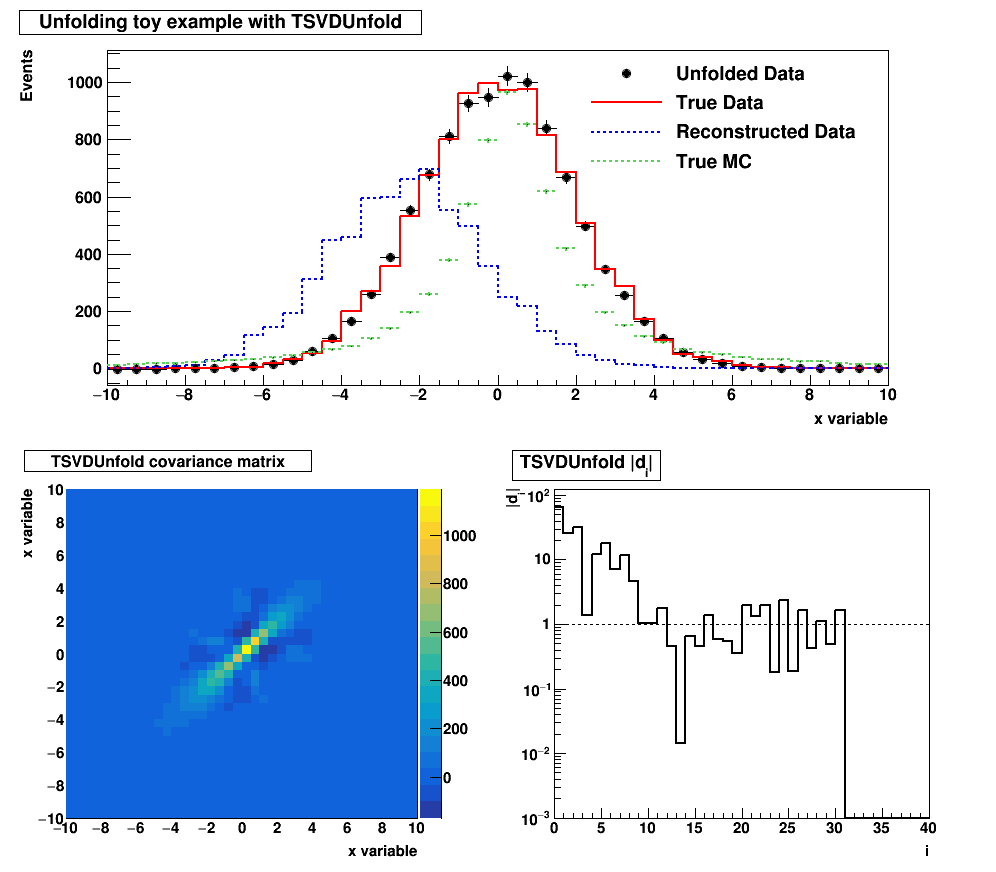

In [26]:
gROOT->GetListOfCanvases()->Draw()